<a href="https://colab.research.google.com/github/dxdiego5/MachineLearning/blob/main/classification_class_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

######imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

###### Funções

In [3]:
def graf_linha(df):
    plt.figure(figsize=(20, 10))
    plt.plot(df)
    plt.show()
    
def graf_histograma(df):
    plt.figure(figsize=(15, 10))
    plt.hist(df, 10, rwidth=0.9)
    plt.show()
    
def info_describe(df):
    print(df.describe())

def graf_boxplot(df):
    sns.boxplot(df)

def filtro_quartil_IIQ(df, col_):
    
  Q1 = np.percentile(df[col_], 25)
  # Q2 = np.percentile(df[col_], 50)
  Q3 = np.percentile(df[col_], 75)

  C = 1.5

  IIQ = Q3 - Q1
  LI = Q1 - (C * IIQ)
  LS = Q3 + (C * IIQ)
  
  df_mask= df[col_] > LI
  amplit_pos = df[df_mask]
  
  df_mask= amplit_pos[col_] < LS
  df = amplit_pos[df_mask]
  # dataframe atualizado sem outliers
  return df

##### Importação da base de dados

In [4]:
df = pd.read_csv('car_ad.csv')
# df.info()
# df.shape
# df.isnull().sum()

##### Limpeza do dataset

In [5]:
## Remoção de dados NAN
df.dropna(axis=0,inplace=True)
df.reset_index(drop=True, inplace=True)

# df.info()
# df.head()

##### Deleção de colunas que eu acho desnecessárias para a analise de classificação

In [6]:
df.drop(['registration','mileage'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

##### Filtragem de dados para a analise limpa 

In [34]:
df_car = df.query("body != 'other'").reset_index(drop=True)

In [ ]:
# df_car.sort_values(by=['model','car'], inplace=True)

##### Transformando os dados em numericos

In [35]:
list_classes_names = df_car.body.unique()

display(list_classes_names)

label_encoder = preprocessing.LabelEncoder()
df_car['car'] = label_encoder.fit_transform(df_car['car'])
df_car['body_norm'] = label_encoder.fit_transform(df_car['body'])
df_car['model'] = label_encoder.fit_transform(df_car['model'])
df_car['drive'] = label_encoder.fit_transform(df_car['drive'])
df_car['engType'] = label_encoder.fit_transform(df_car['engType'])
# df_car['price'] = label_encoder.fit_transform(df_car['price'])
# df_car['year'] = label_encoder.fit_transform(df_car['year'])
# df_car['engV'] = label_encoder.fit_transform(df_car['engV'])

display(df_car.body_norm.unique())

array(['crossover', 'sedan', 'van', 'vagon', 'hatch'], dtype=object)

array([0, 2, 4, 3, 1])

In [ ]:
df_car

##### criacao das classes em dataframes e aplicacao da funcão de filtragem de quartil

In [36]:
df_classes = {}
for class_ in df_car.body.unique():
  df_classes[class_] = df_car.query(f"body == '{class_}'")
  for col_ in ['engV']:
    df_classes[class_] = filtro_quartil_IIQ(df_classes[class_], col_)

##### concatenação dos dataframes por classe apos filtragem

In [37]:
list_classes_names = df_car.body.unique()
df_car = pd.concat([df_classes[class_]  for class_ in list_classes_names]).reset_index(drop=True)

In [ ]:
# df_car

##### Analise especificas

In [38]:
df_sem_classe = df_car.drop(['body','body_norm'],axis=1)
df_com_classe = df_car[['body_norm']]

##### Criando modelo 

In [39]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()  
scaler.fit(df_sem_classe)

df_sem_classe_normalizado = scaler.transform(df_sem_classe)


X_train, X_test, y_train, y_test = train_test_split(df_sem_classe_normalizado, df_com_classe, test_size = 0.3, random_state = 0)

In [40]:
# Verificando quantas classes tem o dataset atual
quantidade_classes = y_train['body_norm'].value_counts()
print(quantidade_classes)

2    2195
0    1355
1     714
4     654
3     435
Name: body_norm, dtype: int64


In [41]:
# Aplicando SMOTE
oversample = SMOTE()
X_train_Smote, y_train_Smote = oversample.fit_resample(X_train, y_train)
# X_train_Smote, y_train_Smote = X_train, y_train

# Verificando quantas classes tem o novo dataset
quantidade_classes = y_train_Smote['body_norm'].value_counts()
print(quantidade_classes)

2    2195
1    2195
4    2195
3    2195
0    2195
Name: body_norm, dtype: int64


In [42]:
# CRIANDO E TREINANDO O MODELO 
knn_model = KNeighborsRegressor(n_neighbors=3)

knn_model.fit(X_train_Smote, y_train_Smote)

y_pred  = knn_model.predict(X_test)

In [43]:
## AVALIANDO O MODELO 

y_pred = pd.DataFrame(y_pred)

y_pred = y_pred.astype(int)

print(classification_report(y_pred, y_test))
matriz = confusion_matrix(y_pred, y_test)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       569
           1       0.74      0.51      0.60       469
           2       0.73      0.81      0.77       829
           3       0.32      0.37      0.34       163
           4       0.82      0.90      0.86       265

    accuracy                           0.76      2295
   macro avg       0.71      0.70      0.70      2295
weighted avg       0.76      0.76      0.75      2295



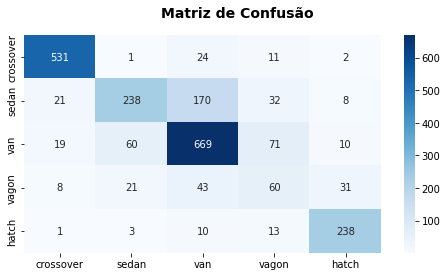

In [44]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('Matriz de Confusão ', fontsize=14, fontweight='bold')
labels = list_classes_names
sns.heatmap(matriz,annot=True, fmt="d",cmap='Blues',xticklabels=labels, yticklabels= labels)